# Progress report 3

*Asura Enkhbayar, 18.06.2020*

Several plots and insights for individual research programs

In [654]:
from pathlib import Path

from IPython.display import Markdown as md

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn3
import pandas as pd
import seaborn as sns

import numpy as np

from tracking_grants import references_f, articles_f, wos_f, altmetric_f, trials_f

In [2]:
sns.set_context("notebook")

# Color palette
cm = "Paired"
cp3 = sns.color_palette(cm, 3)
cp10 = sns.color_palette(cm, 10)

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

## Load Data

In [634]:
# Load references
refs = pd.read_csv(references_f, index_col="reference_id")

In [645]:
# Load matched articles
articles = pd.read_csv(articles_f)
articles.DOI = articles.DOI.str.lower()

In [646]:
# Load metrics from WoS
wos = pd.read_csv(wos_f,  low_memory=False, index_col="DOI")
wos.columns = [x.lower() for x in wos.columns.tolist()]
wos.index = wos.index.str.lower()

wos = wos.rename(columns={'relative citation score':'citation_score'})

In [647]:
# Load metrics from Altmetric
altmetrics = pd.read_json(altmetric_f).T

# Filter out all articles had not altmetrics
altmetrics = altmetrics[altmetrics.altmetric_id.notna()]

In [660]:
trials = pd.read_csv(trials_f)

articles = articles.merge(trials.doi.value_counts().to_frame("n_trials"), left_on="DOI", right_index=True, how="left")

In [666]:
dates = ["last_updated", "published_on", "added_on"]
for d in dates:
    altmetrics[d] = pd.to_datetime(altmetrics[d], unit="s")

str_cols = ["pmid", "pmc", "altmetric_id", "doi", 'hollis_id', "arxiv_id"]
for _ in str_cols:
    altmetrics[_] = altmetrics[_].astype(str)
    
metric_cols = {
    'cited_by_posts_count': 'posts_count',
    'cited_by_rh_count': 'research_highlight',
    'cited_by_tweeters_count': 'twitter_accounts',
    'cited_by_patents_count': 'patents',
    'cited_by_msm_count': 'news_outlets',
    'cited_by_feeds_count': 'blogs',
    'cited_by_fbwalls_count': 'fb_pages',
    'cited_by_qna_count': 'stackoverflow',
    'cited_by_videos_count': 'videos',
    'cited_by_peer_review_sites_count': 'peer_reviews',
    'cited_by_weibo_count': 'weibo',
    'cited_by_gplus_count': 'gplus',
    'cited_by_rdts_count': 'reddit_threads',
    'cited_by_policies_count': 'policies',
    'cited_by_syllabi_count': 'syllabi',
    'cited_by_linkedin_count': 'linkedin',
    'cited_by_wikipedia_count': 'wikipedia',
}
altmetrics = altmetrics.rename(columns=metric_cols)
metric_cols = list(metric_cols.values())

altmetrics[metric_cols] = altmetrics[metric_cols].astype(float)

cols_to_keep = metric_cols + dates + str_cols + ['subjects', 'scopus_subjects']
altmetrics = altmetrics[cols_to_keep]

# Transform all DOIs to lowercase
altmetrics.index = altmetrics.index.str.lower()

In [667]:
metadata = ['grant_id', 'program', 'DOI', 'publisher', 'coci_citations', 'n_trials']
metrics = articles[metadata].merge(altmetrics[metric_cols], left_on="DOI", right_index=True, how="left")
metrics = metrics.merge(wos[["citations", "citation_score"]], left_on="DOI", right_index=True, how="left")

# Replace articles with 0 citations as NaN
metrics = metrics.replace(0.0, np.nan)

# Remove duplicates (multiple reference_ids)
metrics = metrics.drop_duplicates()

In [668]:
metric_cols = ['coci_citations', "citations", "citation_score"] + metric_cols

## Just some stats again...

In [669]:
ms = ['coci_citations', 'citations', 'citation_score', 'fb_pages', 'twitter_accounts']

### Coverage per DOI

In [670]:
df = metrics.drop(columns=["grant_id"]).drop_duplicates()
x = df.groupby("program")['DOI'].nunique().sort_values().to_frame("n_articles")
x[ms] = df.groupby("program")[ms].count()
x[ms] = x[ms].apply(lambda y: 100*y.div(x['n_articles'], axis=0))
x.round(2)

,n_articles,coci_citations,citations,citation_score,fb_pages,twitter_accounts
program,,,,,,
PRORP,1,100.0,0.00,0.00,0.00,0.00
TSCRP,198,100.0,66.16,66.16,14.65,44.44
NFRP,568,100.0,0.00,0.00,0.00,0.00
PCRP,6162,100.0,37.07,37.07,5.91,20.63


### Coverage per Grant ID

In [671]:
df = metrics.groupby(["program", 'grant_id'])[ms].mean().reset_index()
x = df.groupby("program")['grant_id'].size().sort_values().to_frame("n_grants")
x[ms] = df.groupby("program")[ms].count()
x[ms] = x[ms].apply(lambda y: 100*y.div(x['n_grants'], axis=0))
x.round(2)

,n_grants,coci_citations,citations,citation_score,fb_pages,twitter_accounts
program,,,,,,
PRORP,1,100.0,0.00,0.00,0.00,0.00
TSCRP,85,100.0,70.59,70.59,25.88,64.71
NFRP,186,100.0,0.00,0.00,0.00,0.00
PCRP,1960,100.0,53.21,53.21,14.85,37.91


## Results aggregated on the grant level (all following plots are per grant)

In [681]:
ms = ['coci_citations', 'citations', 'citation_score', 'fb_pages', 'twitter_accounts']

# Remove ref_id, grant_id, and score (!) as the individual references deposited might apply to various grants and even contain slightly different formats for the publications
grants = metrics
grants = grants.groupby(["program", 'grant_id']).mean().reset_index()

grants = grants.merge(metrics.groupby("grant_id")['DOI'].nunique().to_frame("n_dois"), left_on="grant_id", right_index=True)
grants = grants.merge(articles.groupby("grant_id").created.mean(), left_on="grant_id", right_index=True)
grants = grants.merge(articles.groupby("grant_id").authors_count.mean(), left_on="grant_id", right_index=True)

grants = grants[grants.program!="PRORP"]

### Coverage for grants

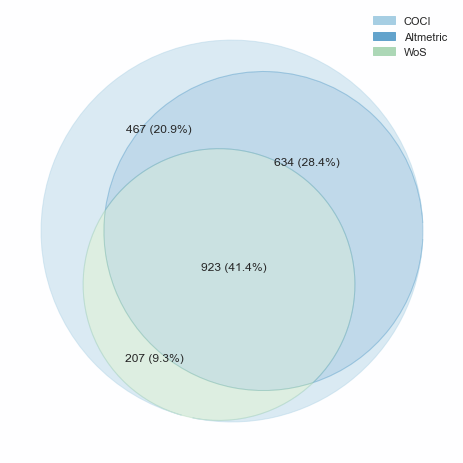

In [683]:
all_articles = set(grants.grant_id.unique().tolist())
articles_w_altm = set(articles[articles.DOI.isin(altmetrics.index)].grant_id.unique().tolist())
articles_w_cit = set(articles[articles.DOI.isin(wos.index)].grant_id.unique().tolist())

total = len(all_articles)

v = venn3([all_articles, articles_w_altm, articles_w_cit],
      set_labels=('', '', ''),
      subset_label_formatter=lambda x: "{:,} ({:.1f}%)".format(x, 100*x/total));

v.get_patch_by_id('100').set_color(cp3[0])
v.get_patch_by_id('110').set_color(np.add(cp3[0], cp3[1])/2)
v.get_patch_by_id('101').set_color(np.add(cp3[0], cp3[2])/2)
v.get_patch_by_id('111').set_color(np.add(np.add(cp3[1], cp3[0]), cp3[2]) / 3)

for text in v.set_labels:
    text.set_fontsize(10)
# for text in v.subset_labels:
#     text.set_fontsize(12)

handles = []
labels=["COCI", "Altmetric", "WoS"]
for l, c in zip(labels, [cp3[0], np.add(cp3[0], cp3[1])/2, np.add(cp3[0], cp3[2])/2]):
    handles.append(mpatches.Patch(color=c, label=l))
plt.legend(handles=handles);

In [767]:
grants.coci_citations = grants.coci_citations.replace(0, np.nan)

### Pairwise spearman correlations for metrics with >20 pairs 

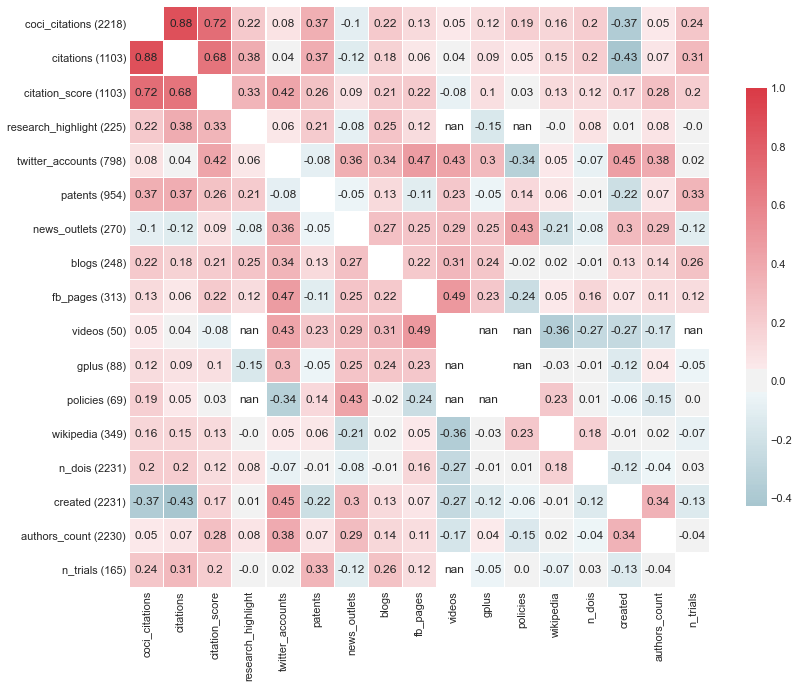

In [768]:
select_cols = [_ for _ in metric_cols if _ not in ['posts_count']]
select_cols = select_cols + ['n_dois', 'created', 'authors_count', 'n_trials']

with sns.axes_style(style="white"):
    corr=grants.drop_duplicates("grant_id")[select_cols].corr(method="spearman", min_periods=20)
    corr = corr.dropna(how="all")
    corr = corr.dropna(how="all", axis=1)
    
    mask = np.zeros((len(corr), len(corr)), dtype=np.bool)
    np.fill_diagonal(mask, True)
    
    f, ax = plt.subplots(figsize=(13, 11))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, mask=mask, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .7})
    
    ax = plt.gca()
    # Loop over data dimensions and create text annotations.
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            if i!=j:
                ax.text(j+.5, i+.5, corr.values[i, j].round(2), ha="center", va="center")
    
    counts = grants.count()
    locs, labels = plt.yticks()
    plt.yticks(locs, [f"{l.get_text()} ({counts[l.get_text()]})" for l in labels])

### Metrics over years

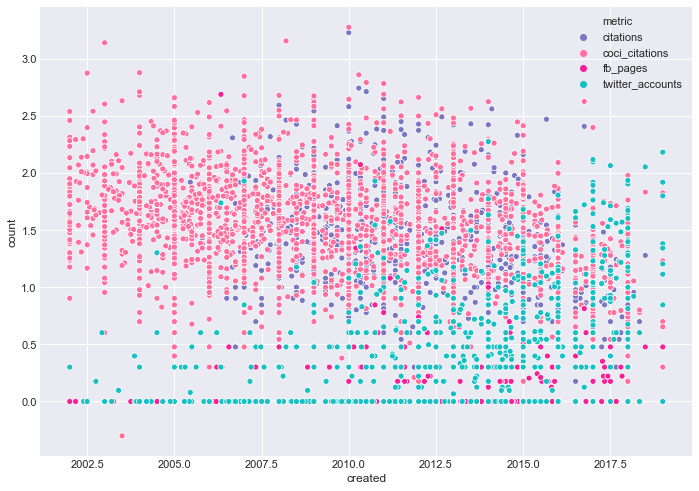

In [779]:
pdf = grants.melt(
    id_vars=["program", "created"],
    value_vars=["citations", "coci_citations", "fb_pages", "twitter_accounts"],
    var_name="metric", value_name="count")
pdf['count'] = np.log10(pdf['count'])
sns.scatterplot(x="created", y="count", hue="metric", data=pdf);

### Pairplot for a selection of variables

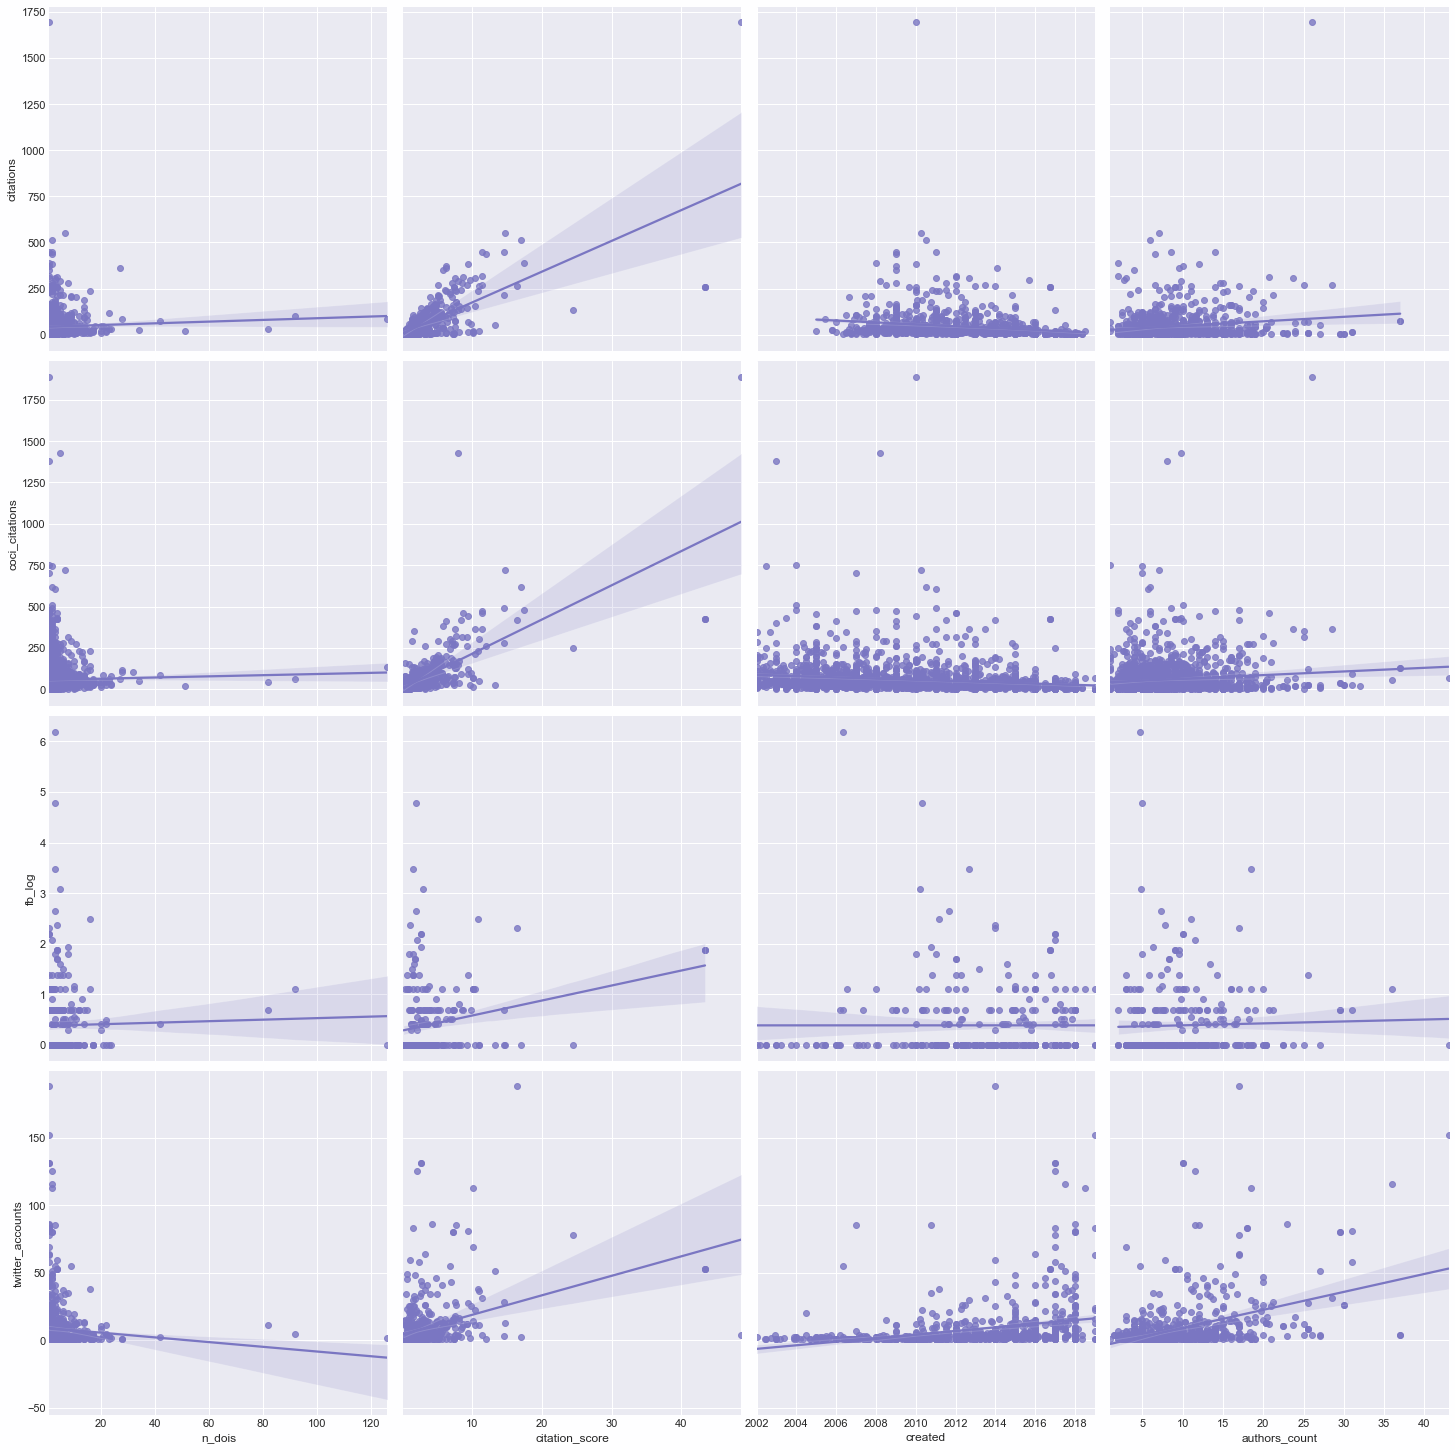

In [614]:
grants['fb_log'] = np.log(grants['fb_pages'])
sns.pairplot(data=grants,
             x_vars=["n_dois", "citation_score", "created", "authors_count"],
             y_vars=["citations", "coci_citations", "fb_log", "twitter_accounts"],
             height=5, kind="reg")

### LinReg for selected metrics over years per program

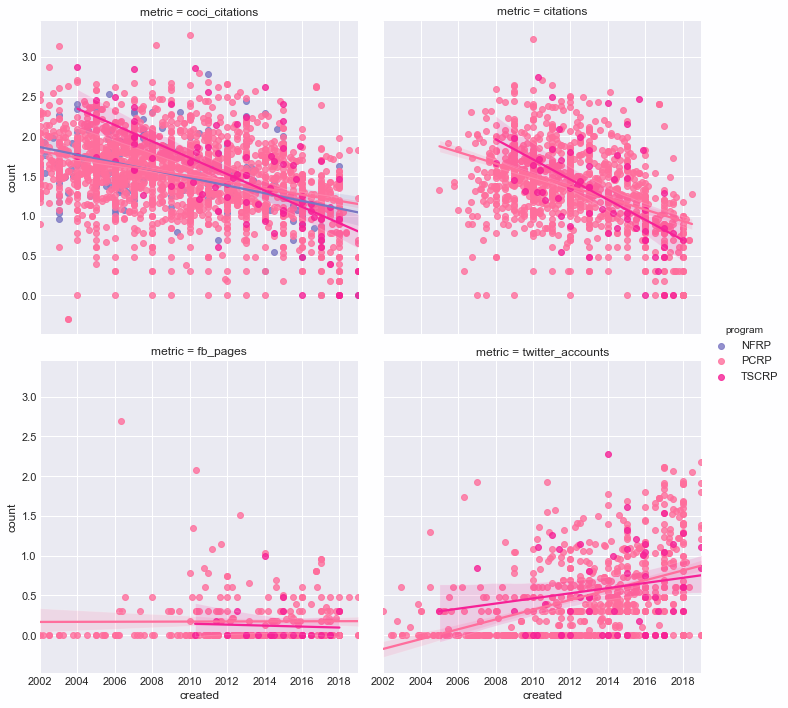

In [608]:
select_cols = ['coci_citations', 'citations', 'fb_pages', 'twitter_accounts']

pdf = grants.melt(id_vars=["n_dois", "citation_score", "created", "program"], value_vars=select_cols, var_name="metric", value_name="count")
pdf['count'] = np.log10(pdf['count'].replace(0, np.nan))
sns.lmplot(x="created", y="count", col="metric", hue="program", col_wrap=2, data=pdf)

# plt.xscale("log")

# plt.yscale("log")
# ticks = [1,10,100,1000]
# plt.yticks(ticks, ticks);

### Normalize metrics across years (just playing around)

```python
def normalize_metric(row, metric, year_span = 1):
    year = row['created']
    competition = grants[(grants.created > year-year_span) & (grants.created < year+year_span)]
    cc = row[metric]
    cc_min = competition[metric].min()
    cc_max = competition[metric].max()
    return (cc - cc_min) / (cc_max - cc_min) 

grants['cc_normed'] = grants.apply(lambda row: normalize_metric(row, "coci_citations", year_span=2), axis=1)
```